<a href="https://colab.research.google.com/github/ycapreddy/EVA8/blob/main/Assignment-8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Run this [network](https://colab.research.google.com/drive/1qlewMtxcAJT6fIJdmMh8pSf2e-dh51Rw) 

Fix the network above:

1. change the code such that it uses GPU and
2. change the architecture to C1C2C3C40 (No MaxPooling, but 3 3x3 layers with stride of 2 instead) (If you can figure out how to use Dilated kernels here instead of MP or strided convolution, then 200pts extra!)
3. total RF must be more than 44
4. one of the layers must use Depthwise Separable Convolution
5. one of the layers must use Dilated Convolution
6. use GAP (compulsory):- add FC after GAP to target #of classes (optional)
7. use albumentation library and apply:
>

> 1. horizontal flip
> 2. shiftScaleRotate
> 3. coarseDropout (max_holes = 1, max_height=16px, max_width=1, min_holes = 1, min_height=16px, min_width=16px, fill_value=(mean of your dataset), mask_fill_value = None)
8. achieve 85% accuracy, as many epochs as you want. Total Params to be less than 200k.

In [2]:
import torch.nn as nn
import torch.nn.functional as F

#depthwise separable convolution
class DepthwiseSeparable(nn.Module):
  def __init__(self, in_ch, out_ch, stride=1):
    super(DepthwiseSeparable, self).__init__()
    self.in_chan = in_ch
    self.out_chan = out_ch

    self.depthwise = nn.Sequential(
          nn.Conv2d(in_channels=self.in_chan, out_channels=self.in_chan, kernel_size=(3, 3), padding=1, stride=stride, groups=self.in_chan, bias=False),
          #pointwise
          nn.Conv2d(in_channels=self.in_chan, out_channels=self.out_chan, kernel_size=(1,1)))

  def forward(self, x):
    x = self.depthwise(x)
    return x

class Net(nn.Module):
    def __init__(self, drop=0.025):
        super(Net, self).__init__()

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),  # Input: 32x32x3 | Output: 32x32x32 | RF: 3x3
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(drop),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),   # Input: 32x32x32 | Output: 32x32x32 | RF: 5x5
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(drop),
        )

        self.transblock1 =  nn.Sequential(
            #Stride 2 conv
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, stride=2, bias=False),  # Input: 32x32x32 | Output: 16x16x32 | RF: 7x7
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(drop),

        )

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),   # Input: 16x16x32 | Output: 16x16x64 | RF: 11x11
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(drop),  

        ) 

        self.transblock2 =  nn.Sequential(
            #Stride 2 conv
            DepthwiseSeparable(64,64,2), # Input: 16x16x64 | Output: 8x8x64 | RF: 15x15
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(drop),
        )

        self.convblock3 = nn.Sequential(
            DepthwiseSeparable(64, 128), # Input: 8x8x64 | Output: 8x8x128 | RF: 23x23
            # nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(drop),  
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(1, 1), bias=False), # Input: 8x8x128 | Output: 8x8x32 | RF: 23x23
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(drop), 

        ) 

        self.transblock3 =  nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, dilation=2, bias=False), # Input: 8x8x128 | Output: 6x6x32 | RF: 39x39
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, dilation=2, bias=False), # Input: 6x6x32 | Output: 4x4x32 | RF: 55x55
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(drop),
        )

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False), # Input: 4x4x32 | Output: 4x4x32 | RF: 63x63
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(3, 3), padding=1, bias=False), # Input: 4x4x32 | Output: 4x4x10 | RF: 71x71

        ) 

        self.gap = nn.AvgPool2d(4)

    def forward(self, x):
        x =  self.transblock1(self.convblock1(x))
        x =  self.transblock2(self.convblock2(x))
        x =  self.transblock3(self.convblock3(x))
        x =  self.convblock4(x)
        x =  self.gap(x)
        x = x.view(-1, 10)
        
        return F.log_softmax(x, dim=-1)

In [3]:
import matplotlib.pyplot as plt
import numpy as np

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms
from tqdm import tqdm

In [4]:
# loading the dataset
exp = datasets.CIFAR10('./data', train=True, download=True)
exp_data = exp.data

# Calculate the mean and std for normalization
print('[Train]')
print(' - Numpy Shape:', exp_data.shape)
print(' - min:', np.min(exp_data, axis=(0,1,2)) / 255.)
print(' - max:', np.max(exp_data, axis=(0,1,2)) / 255.)
print(' - mean:', np.mean(exp_data, axis=(0,1,2)) / 255.)
print(' - std:', np.std(exp_data, axis=(0,1,2)) / 255.)
print(' - var:', np.var(exp_data, axis=(0,1,2)) / 255.)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
[Train]
 - Numpy Shape: (50000, 32, 32, 3)
 - min: [0. 0. 0.]
 - max: [1. 1. 1.]
 - mean: [0.49139968 0.48215841 0.44653091]
 - std: [0.24703223 0.24348513 0.26158784]
 - var: [15.56135559 15.11767693 17.44919073]


In [5]:
exp.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
def viz_data(cols=8, rows=5):
  figure = plt.figure(figsize=(14, 10))
  for i in range(1, cols * rows + 1):
    img, label = exp[i]

    figure.add_subplot(rows, cols, i)
    plt.title(exp.classes[label])
    plt.axis("off")
    plt.imshow(img, cmap="gray")

  plt.tight_layout()
  plt.show()

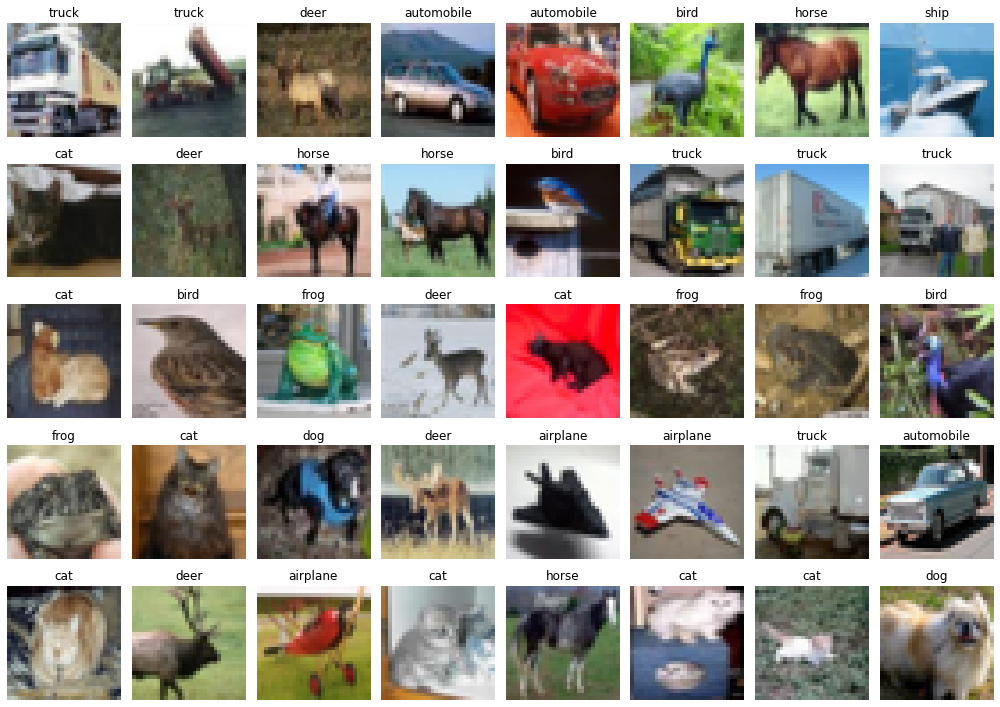

In [7]:
viz_data()


In [8]:
def show_images(aug_dict, ncol=6):
  nrow = len(aug_dict)

  fig, axes = plt.subplots(ncol, nrow, figsize=( 3*nrow, 15), squeeze=False)
  for i, (key, aug) in enumerate(aug_dict.items()):
    for j in range(ncol):
      ax = axes[j,i]
      if j == 0:
        ax.text(0.5, 0.5, key, horizontalalignment='center', verticalalignment='center', fontsize=15)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.axis('off')
      else:
        image, label = exp[j-1]
        if aug is not None:
          transform = A.Compose([aug])
          image = np.array(image)
          image = transform(image=image)['image']
          
        ax.imshow(image)
        ax.set_title(f'{exp.classes[label]}')
        ax.axis('off')

  plt.tight_layout()
  plt.show()

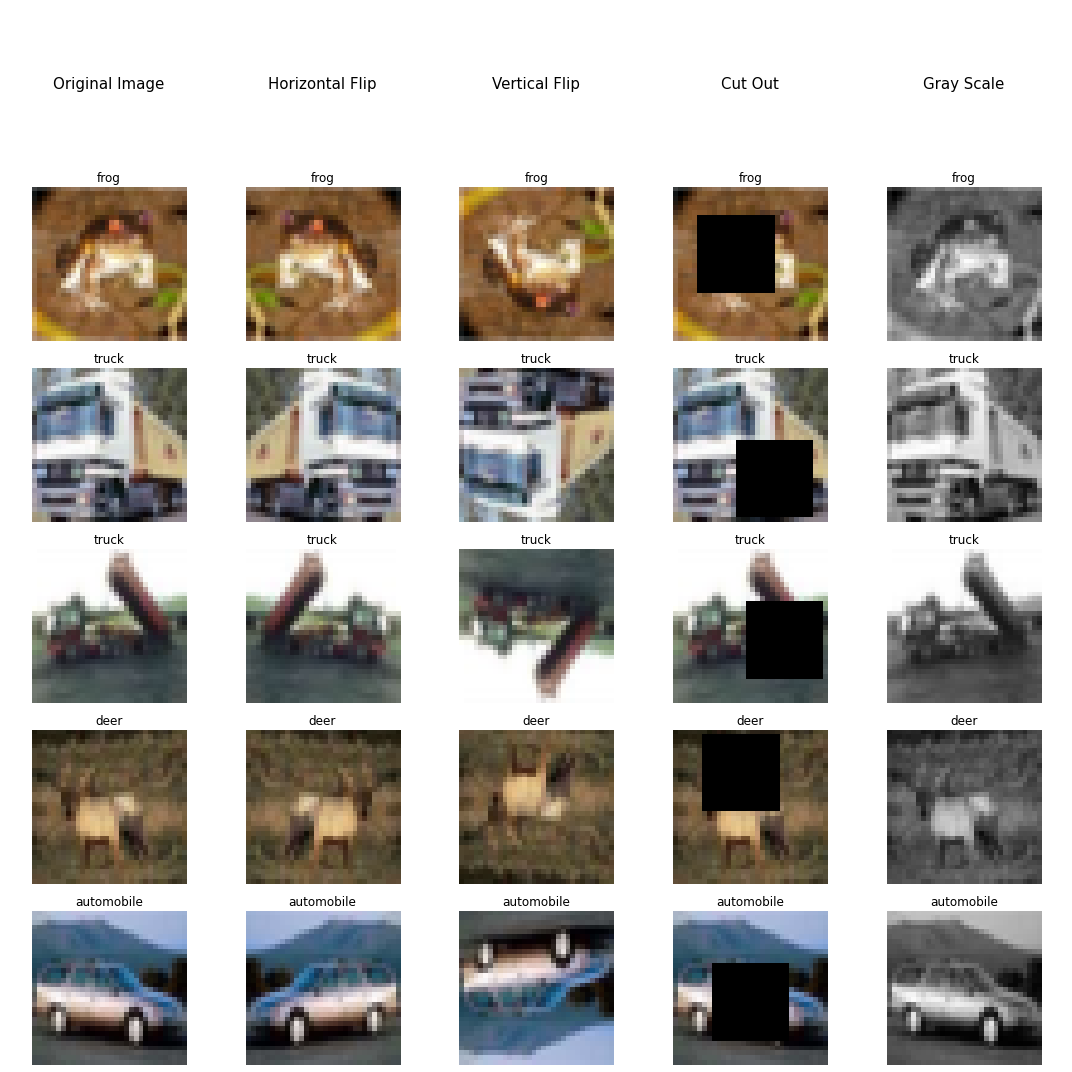

In [9]:
show_images({
    'Original Image': None,
    'Horizontal Flip': A.HorizontalFlip(always_apply=True),
    'Vertical Flip': A.VerticalFlip(always_apply=True),
    'Cut Out': A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, 
                               min_width=16, fill_value=0.473363, mask_fill_value=None, always_apply=True),
    'Gray Scale': A.ToGray(always_apply=True)
})

In [10]:
# custom dataset class for albumentations library
class AlbumentationImageDataset(Dataset):
  def __init__(self, image_list, train= True):
      self.image_list = image_list
      self.aug = A.Compose({
          A.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)),
          A.HorizontalFlip(),
          A.ShiftScaleRotate(),
          A.CoarseDropout(1, 16, 16, 1, 16, 16,fill_value=0.473363, mask_fill_value=None),
          A.ToGray()
      })

      self.norm = A.Compose({A.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)),
      })
      self.train = train
        
  def __len__(self):
      return (len(self.image_list))

  def __getitem__(self, i):
      
      image, label = self.image_list[i]
      
      if self.train:
        #apply augmentation only for training
        image = self.aug(image=np.array(image))['image']
      else:
        image = self.norm(image=np.array(image))['image']
      image = np.transpose(image, (2, 0, 1)).astype(np.float32)
      return torch.tensor(image, dtype=torch.float), label

In [11]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available:", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
    BATCH_SIZE=64
else:
    BATCH_SIZE=64

CUDA Available: True


In [12]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True )
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True)


train_loader = torch.utils.data.DataLoader(AlbumentationImageDataset(trainset, train=True), batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(AlbumentationImageDataset(testset, train=False), batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
net = Net(drop=0.0).to(device)
summary(net, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 16, 16]           9,216
      BatchNorm2d-10           [-1, 32, 16, 16]              64
             ReLU-11           [-1, 32, 16, 16]               0
          Dropout-12           [-1, 32, 16, 16]               0
           Conv2d-13           [-1, 64, 16, 16]          18,432
      BatchNorm2d-14           [-1

In [14]:
def train(model, device, train_loader, optimizer, l1, scheduler):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  num_loops = 0
  train_loss = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch 
    # accumulates the gradients on subsequent backward passes. Because of this, when you start your training loop, 
    # ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    l1 = 0
    lambda_l1 = 0.01
    if l1:
      for p in model.parameter():
        l1 = l1 + p.abs().sum()
    
    loss = loss + lambda_l1*l1

    # Backpropagation
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

    # Update LR
    scheduler.step()
    
    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    num_loops += 1
    pbar.set_description(desc= f'Batch_id={batch_idx} Loss={train_loss/num_loops:.5f} Accuracy={100*correct/processed:0.2f}')
  
  return 100*correct/processed, train_loss/num_loops

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    
    return 100. * correct / len(test_loader.dataset), test_loss

def fit_model(net, NUM_EPOCHS=20, l1=False, l2=False):
  training_acc, training_loss, testing_acc, testing_loss = list(), list(), list(), list()
  
  if l2:
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
  else:
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
  scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.017, epochs=NUM_EPOCHS, steps_per_epoch=len(train_loader))

  for epoch in range(1,NUM_EPOCHS+1):
      print("EPOCH:", epoch)
      train_acc, train_loss = train(net, device, train_loader, optimizer, l1, scheduler)
      test_acc, test_loss = test(net, device, test_loader)

      training_acc.append(train_acc)
      training_loss.append(train_loss)
      testing_acc.append(test_acc)
      testing_loss.append(test_loss)
      
  return net, (training_acc, training_loss, testing_acc, testing_loss)

In [ ]:
net, history = fit_model(net, NUM_EPOCHS=24)

EPOCH: 1


Batch_id=781 Loss=2.06376 Accuracy=21.91: 100%|██████████| 782/782 [00:21<00:00, 36.56it/s]



Test set: Average loss: 1.7033, Accuracy: 3787/10000 (37.87%)

EPOCH: 2


Batch_id=781 Loss=1.66382 Accuracy=38.54: 100%|██████████| 782/782 [00:20<00:00, 37.38it/s]



Test set: Average loss: 1.4377, Accuracy: 4733/10000 (47.33%)

EPOCH: 3


Batch_id=781 Loss=1.49997 Accuracy=45.68: 100%|██████████| 782/782 [00:21<00:00, 36.47it/s]



Test set: Average loss: 1.1908, Accuracy: 5773/10000 (57.73%)

EPOCH: 4


Batch_id=781 Loss=1.34941 Accuracy=52.02: 100%|██████████| 782/782 [00:20<00:00, 37.60it/s]



Test set: Average loss: 1.1546, Accuracy: 6072/10000 (60.72%)

EPOCH: 5


Batch_id=781 Loss=1.26585 Accuracy=55.49: 100%|██████████| 782/782 [00:19<00:00, 39.27it/s]



Test set: Average loss: 0.9954, Accuracy: 6584/10000 (65.84%)

EPOCH: 6


Batch_id=781 Loss=1.19787 Accuracy=57.88: 100%|██████████| 782/782 [00:20<00:00, 38.27it/s]



Test set: Average loss: 0.8838, Accuracy: 6912/10000 (69.12%)

EPOCH: 7


Batch_id=781 Loss=1.14498 Accuracy=59.85: 100%|██████████| 782/782 [00:21<00:00, 37.18it/s]



Test set: Average loss: 0.9066, Accuracy: 6857/10000 (68.57%)

EPOCH: 8


Batch_id=781 Loss=1.09889 Accuracy=61.79: 100%|██████████| 782/782 [00:21<00:00, 36.95it/s]



Test set: Average loss: 0.7925, Accuracy: 7230/10000 (72.30%)

EPOCH: 9


Batch_id=781 Loss=1.06387 Accuracy=62.86: 100%|██████████| 782/782 [00:21<00:00, 36.75it/s]



Test set: Average loss: 0.8141, Accuracy: 7209/10000 (72.09%)

EPOCH: 10


Batch_id=781 Loss=1.03424 Accuracy=63.79: 100%|██████████| 782/782 [00:21<00:00, 36.76it/s]



Test set: Average loss: 0.7158, Accuracy: 7502/10000 (75.02%)

EPOCH: 11


Batch_id=781 Loss=1.01017 Accuracy=64.57: 100%|██████████| 782/782 [00:19<00:00, 39.44it/s]



Test set: Average loss: 0.7361, Accuracy: 7535/10000 (75.35%)

EPOCH: 12


Batch_id=781 Loss=0.98765 Accuracy=65.76: 100%|██████████| 782/782 [00:19<00:00, 39.21it/s]



Test set: Average loss: 0.8026, Accuracy: 7237/10000 (72.37%)

EPOCH: 13


Batch_id=781 Loss=0.96687 Accuracy=66.19: 100%|██████████| 782/782 [00:21<00:00, 36.62it/s]



Test set: Average loss: 0.7572, Accuracy: 7478/10000 (74.78%)

EPOCH: 14


Batch_id=781 Loss=0.94316 Accuracy=67.02: 100%|██████████| 782/782 [00:21<00:00, 36.70it/s]



Test set: Average loss: 0.6525, Accuracy: 7753/10000 (77.53%)

EPOCH: 15


Batch_id=781 Loss=0.92469 Accuracy=67.61: 100%|██████████| 782/782 [00:21<00:00, 36.79it/s]



Test set: Average loss: 0.6152, Accuracy: 7896/10000 (78.96%)

EPOCH: 16


Batch_id=781 Loss=0.90284 Accuracy=68.53: 100%|██████████| 782/782 [00:21<00:00, 37.12it/s]



Test set: Average loss: 0.6352, Accuracy: 7852/10000 (78.52%)

EPOCH: 17


Batch_id=259 Loss=0.88741 Accuracy=69.19:  33%|███▎      | 260/782 [00:06<00:13, 39.85it/s]

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

#depthwise separable convolution
class DepthwiseSeparable(nn.Module):
  def __init__(self, in_ch, out_ch, stride=1):
    super(DepthwiseSeparable, self).__init__()
    self.in_chan = in_ch
    self.out_chan = out_ch

    self.depthwise = nn.Sequential(
          nn.Conv2d(in_channels=self.in_chan, out_channels=self.in_chan, kernel_size=(3, 3), padding=1, stride=stride, groups=self.in_chan, bias=False),
          #pointwise
          nn.Conv2d(in_channels=self.in_chan, out_channels=self.out_chan, kernel_size=(1,1)))

  def forward(self, x):
    x = self.depthwise(x)
    return x

class Net2(nn.Module):
    def __init__(self, drop=0.025):
        super(Net2, self).__init__()

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(drop),
            DepthwiseSeparable(32,32,2), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(drop),
        )

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(drop),
            DepthwiseSeparable(64,64,2), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(drop),
        )

        self.convblock3 =  nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, dilation=2, bias=False),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, dilation=2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(drop),
        )

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3, 3), padding=1, bias=False), 
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(3, 3), padding=1, bias=False), 

        ) 

        self.gap = nn.AvgPool2d(4)

    def forward(self, x):
        x =  self.convblock1(x)
        #print(x.shape)
        x =  self.convblock2(x)
        #print(x.shape)
        x =  self.convblock3(x)
        #print(x.shape)
        x =  self.convblock4(x)
        #print(x.shape)
        x =  self.gap(x)
        x = x.view(-1, 10)
        
        return F.log_softmax(x, dim=-1)

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
net2 = Net2(drop=0.0).to(device)
summary(net2, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 16, 16]             288
            Conv2d-6           [-1, 32, 16, 16]           1,056
DepthwiseSeparable-7           [-1, 32, 16, 16]               0
       BatchNorm2d-8           [-1, 32, 16, 16]              64
              ReLU-9           [-1, 32, 16, 16]               0
          Dropout-10           [-1, 32, 16, 16]               0
           Conv2d-11           [-1, 64, 16, 16]          18,432
      BatchNorm2d-12           [-1, 64, 16, 16]             128
             ReLU-13           [-1, 64, 16, 16]               0
          Dropout-14           [-1

In [ ]:
net2, history = fit_model(net2, NUM_EPOCHS=30)

EPOCH: 1


Batch_id=781 Loss=2.04842 Accuracy=23.56: 100%|██████████| 782/782 [00:18<00:00, 42.71it/s]



Test set: Average loss: 1.5836, Accuracy: 4043/10000 (40.43%)

EPOCH: 2


Batch_id=781 Loss=1.65063 Accuracy=39.34: 100%|██████████| 782/782 [00:19<00:00, 40.74it/s]



Test set: Average loss: 1.3267, Accuracy: 5016/10000 (50.16%)

EPOCH: 3


Batch_id=781 Loss=1.48775 Accuracy=46.64: 100%|██████████| 782/782 [00:20<00:00, 38.76it/s]



Test set: Average loss: 1.2172, Accuracy: 5714/10000 (57.14%)

EPOCH: 4


Batch_id=781 Loss=1.38401 Accuracy=50.72: 100%|██████████| 782/782 [00:19<00:00, 39.12it/s]



Test set: Average loss: 1.1281, Accuracy: 6076/10000 (60.76%)

EPOCH: 5


Batch_id=781 Loss=1.30888 Accuracy=53.58: 100%|██████████| 782/782 [00:19<00:00, 40.79it/s]



Test set: Average loss: 1.1639, Accuracy: 6038/10000 (60.38%)

EPOCH: 6


Batch_id=781 Loss=1.25097 Accuracy=55.72: 100%|██████████| 782/782 [00:19<00:00, 40.32it/s]



Test set: Average loss: 0.9627, Accuracy: 6668/10000 (66.68%)

EPOCH: 7


Batch_id=781 Loss=1.19707 Accuracy=57.69: 100%|██████████| 782/782 [00:19<00:00, 39.26it/s]



Test set: Average loss: 0.8515, Accuracy: 7044/10000 (70.44%)

EPOCH: 8


Batch_id=781 Loss=1.16033 Accuracy=58.90: 100%|██████████| 782/782 [00:19<00:00, 41.07it/s]



Test set: Average loss: 0.9690, Accuracy: 6772/10000 (67.72%)

EPOCH: 9


Batch_id=781 Loss=1.11467 Accuracy=61.00: 100%|██████████| 782/782 [00:19<00:00, 41.15it/s]



Test set: Average loss: 0.8076, Accuracy: 7202/10000 (72.02%)

EPOCH: 10


Batch_id=781 Loss=1.08594 Accuracy=61.90: 100%|██████████| 782/782 [00:20<00:00, 38.76it/s]



Test set: Average loss: 0.8009, Accuracy: 7177/10000 (71.77%)

EPOCH: 11


Batch_id=781 Loss=1.05754 Accuracy=62.52: 100%|██████████| 782/782 [00:19<00:00, 39.56it/s]



Test set: Average loss: 0.8282, Accuracy: 7131/10000 (71.31%)

EPOCH: 12


Batch_id=781 Loss=1.03326 Accuracy=63.47: 100%|██████████| 782/782 [00:18<00:00, 41.31it/s]



Test set: Average loss: 0.7148, Accuracy: 7520/10000 (75.20%)

EPOCH: 13


Batch_id=781 Loss=1.00582 Accuracy=64.71: 100%|██████████| 782/782 [00:19<00:00, 39.79it/s]



Test set: Average loss: 0.7071, Accuracy: 7562/10000 (75.62%)

EPOCH: 14


Batch_id=781 Loss=0.98660 Accuracy=65.27: 100%|██████████| 782/782 [00:20<00:00, 38.51it/s]



Test set: Average loss: 0.7294, Accuracy: 7477/10000 (74.77%)

EPOCH: 15


Batch_id=781 Loss=0.97610 Accuracy=65.75: 100%|██████████| 782/782 [00:23<00:00, 33.72it/s]



Test set: Average loss: 0.6867, Accuracy: 7654/10000 (76.54%)

EPOCH: 16


Batch_id=781 Loss=0.95845 Accuracy=66.52: 100%|██████████| 782/782 [00:23<00:00, 33.78it/s]



Test set: Average loss: 0.6620, Accuracy: 7694/10000 (76.94%)

EPOCH: 17


Batch_id=781 Loss=0.93959 Accuracy=67.06: 100%|██████████| 782/782 [00:23<00:00, 33.68it/s]



Test set: Average loss: 0.6634, Accuracy: 7729/10000 (77.29%)

EPOCH: 18


Batch_id=781 Loss=0.93041 Accuracy=67.45: 100%|██████████| 782/782 [00:23<00:00, 32.65it/s]



Test set: Average loss: 0.6604, Accuracy: 7711/10000 (77.11%)

EPOCH: 19


Batch_id=781 Loss=0.91264 Accuracy=68.08: 100%|██████████| 782/782 [00:19<00:00, 39.52it/s]



Test set: Average loss: 0.5981, Accuracy: 7923/10000 (79.23%)

EPOCH: 20


Batch_id=781 Loss=0.89785 Accuracy=68.56: 100%|██████████| 782/782 [00:19<00:00, 39.62it/s]



Test set: Average loss: 0.6108, Accuracy: 7888/10000 (78.88%)

EPOCH: 21


Batch_id=781 Loss=0.88032 Accuracy=69.15: 100%|██████████| 782/782 [00:23<00:00, 32.67it/s]



Test set: Average loss: 0.5814, Accuracy: 8007/10000 (80.07%)

EPOCH: 22


Batch_id=781 Loss=0.87319 Accuracy=69.17: 100%|██████████| 782/782 [00:21<00:00, 37.04it/s]



Test set: Average loss: 0.5825, Accuracy: 7995/10000 (79.95%)

EPOCH: 23


Batch_id=781 Loss=0.85149 Accuracy=70.04: 100%|██████████| 782/782 [00:20<00:00, 38.81it/s]



Test set: Average loss: 0.5793, Accuracy: 7996/10000 (79.96%)

EPOCH: 24


Batch_id=781 Loss=0.84133 Accuracy=70.58: 100%|██████████| 782/782 [00:21<00:00, 36.80it/s]



Test set: Average loss: 0.5835, Accuracy: 8054/10000 (80.54%)

EPOCH: 25


Batch_id=781 Loss=0.82617 Accuracy=70.74: 100%|██████████| 782/782 [00:20<00:00, 38.18it/s]



Test set: Average loss: 0.5435, Accuracy: 8167/10000 (81.67%)

EPOCH: 26


Batch_id=781 Loss=0.80794 Accuracy=71.49: 100%|██████████| 782/782 [00:19<00:00, 40.41it/s]



Test set: Average loss: 0.5445, Accuracy: 8110/10000 (81.10%)

EPOCH: 27


Batch_id=781 Loss=0.79961 Accuracy=71.73: 100%|██████████| 782/782 [00:19<00:00, 40.07it/s]



Test set: Average loss: 0.5388, Accuracy: 8157/10000 (81.57%)

EPOCH: 28


Batch_id=781 Loss=0.78783 Accuracy=72.51: 100%|██████████| 782/782 [00:20<00:00, 38.02it/s]



Test set: Average loss: 0.5204, Accuracy: 8235/10000 (82.35%)

EPOCH: 29


Batch_id=781 Loss=0.77611 Accuracy=72.62: 100%|██████████| 782/782 [00:20<00:00, 38.18it/s]



Test set: Average loss: 0.5265, Accuracy: 8227/10000 (82.27%)

EPOCH: 30


Batch_id=781 Loss=0.77239 Accuracy=72.83: 100%|██████████| 782/782 [00:19<00:00, 40.10it/s]



Test set: Average loss: 0.5193, Accuracy: 8241/10000 (82.41%)



3rd Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

#depthwise separable convolution
class DepthwiseSeparable(nn.Module):
  def __init__(self, in_ch, out_ch, stride=1):
    super(DepthwiseSeparable, self).__init__()
    self.in_chan = in_ch
    self.out_chan = out_ch

    self.depthwise = nn.Sequential(
          nn.Conv2d(in_channels=self.in_chan, out_channels=self.in_chan, kernel_size=(3, 3), padding=1, stride=stride, groups=self.in_chan, bias=False),
          #pointwise
          nn.Conv2d(in_channels=self.in_chan, out_channels=self.out_chan, kernel_size=(1,1)))

  def forward(self, x):
    x = self.depthwise(x)
    return x

class Net3(nn.Module):
    def __init__(self, drop=0.025):
        super(Net3, self).__init__()

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(drop),
            DepthwiseSeparable(32,32,2), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(drop),
        )

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(drop),
            DepthwiseSeparable(64,64,2), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(drop),
        )

        self.convblock3 =  nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, dilation=2, bias=False),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, dilation=2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(drop),
        )

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3, 3), padding=1, bias=False), 
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(3, 3), padding=1, bias=False), 

        ) 

        self.gap = nn.AvgPool2d(4)

    def forward(self, x):
        x =  self.convblock1(x)
        #print(x.shape)
        x =  self.convblock2(x)
        #print(x.shape)
        x =  self.convblock3(x)
        #print(x.shape)
        x =  self.convblock4(x)
        #print(x.shape)
        x =  self.gap(x)
        x = x.view(-1, 10)
        
        return F.log_softmax(x, dim=-1)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms
from tqdm import tqdm

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
net3 = Net3(drop=0.0).to(device)
summary(net3, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 16, 16]             288
            Conv2d-6           [-1, 32, 16, 16]           1,056
DepthwiseSeparable-7           [-1, 32, 16, 16]               0
       BatchNorm2d-8           [-1, 32, 16, 16]              64
              ReLU-9           [-1, 32, 16, 16]               0
          Dropout-10           [-1, 32, 16, 16]               0
           Conv2d-11           [-1, 64, 16, 16]          18,432
      BatchNorm2d-12           [-1, 64, 16, 16]             128
             ReLU-13           [-1, 64, 16, 16]               0
          Dropout-14           [-1

In [ ]:
!pip install torch_lr_finder
from torch_lr_finder import LRFinder


def find_lr(net, optimizer, criterion, train_loader):
    """Find learning rate for using One Cyclic LRFinder
    Args:
        net (instace): torch instace of defined model
        optimizer (instance): optimizer to be used
        criterion (instance): criterion to be used for calculating loss
        train_loader (instance): torch dataloader instace for trainig set
    """
    lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
    lr_finder.range_test(train_loader, end_lr=10, num_iter=100, step_mode="exp")
    lr_finder.plot()
    lr_finder.reset()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
class AlbumentationImageDataset(Dataset):
  def __init__(self, image_list, train= True):
      self.image_list = image_list
      self.aug = A.Compose({
          A.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)),
          A.HorizontalFlip(),
          A.ShiftScaleRotate(),
          A.CoarseDropout(1, 16, 16, 1, 16, 16,fill_value=0.473363, mask_fill_value=None),
          A.ToGray()
      })

      self.norm = A.Compose({A.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)),
      })
      self.train = train
        
  def __len__(self):
      return (len(self.image_list))

  def __getitem__(self, i):
      
      image, label = self.image_list[i]
      
      if self.train:
        #apply augmentation only for training
        image = self.aug(image=np.array(image))['image']
      else:
        image = self.norm(image=np.array(image))['image']
      image = np.transpose(image, (2, 0, 1)).astype(np.float32)
      return torch.tensor(image, dtype=torch.float), label

In [ ]:
cuda = torch.cuda.is_available()
print("CUDA Available:", cuda)
SEED = 1
# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
    BATCH_SIZE=512
else:
    BATCH_SIZE=32
    
print(f'Batch Size: {BATCH_SIZE}')

CUDA Available: True
Batch Size: 512


In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True )
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True)


train_loader = torch.utils.data.DataLoader(AlbumentationImageDataset(trainset, train=True), batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(AlbumentationImageDataset(testset, train=False), batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=1)
    

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
import numpy as np
import torch
from tqdm import tqdm


def train(model, device, train_loader, criterion, scheduler, optimizer, use_l1=False, lambda_l1=0.01):
    """Function to train the model

    Args:
        model (instance): torch model instance of defined model
        device (str): "cpu" or "cuda" device to be used
        train_loader (instance): Torch Dataloader instance for trainingset
        criterion (instance): criterion to used for calculating the loss
        scheduler (function): scheduler to be used
        optimizer (function): optimizer to be used
        use_l1 (bool, optional): L1 Regularization method set True to use . Defaults to False.
        lambda_l1 (float, optional): Regularization parameter of L1. Defaults to 0.01.

    Returns:
        float: accuracy and loss values
    """
    model.train()
    pbar = tqdm(train_loader)
    lr_trend = []
    correct = 0
    processed = 0
    train_loss = 0

    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch 
        # accumulates the gradients on subsequent backward passes. Because of this, when you start your training loop, 
        # ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)
        # Calculate loss
        loss = criterion(y_pred, target)

        l1=0
        if use_l1:
            for p in model.parameters():
                l1 = l1 + p.abs().sum()
        loss = loss + lambda_l1*l1

        # Backpropagation
        loss.backward()
        optimizer.step()
        # updating LR
        if scheduler:
            if not isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step()
                lr_trend.append(scheduler.get_last_lr()[0])

        train_loss += loss.item()

        # Update pbar-tqdm
        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        

        pbar.set_description(desc= f'Batch_id={batch_idx} Loss={train_loss/(batch_idx + 1):.5f} Accuracy={100*correct/processed:0.2f}%')
    return 100*correct/processed, train_loss/(batch_idx + 1), lr_trend


def test(model, device, test_loader, criterion):
    """put model in eval mode and test it

    Args:
        model (instance): torch model instance of defined model
        device (str): "cpu" or "cuda" device to be used
        test_loader (instance): Torch Dataloader instance for testset
        criterion (instance): criterion to used for calculating the loss

    Returns:
        float: accuracy and loss values
    """
    model.eval()
    test_loss = 0
    correct = 0
    #iteration = len(test_loader.dataset)// test_loader.batch_size
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset), test_loss


def save_model(model, epoch, optimizer, path):
    """Save torch model in .pt format

    Args:
        model (instace): torch instance of model to be saved
        epoch (int): epoch num
        optimizer (instance): torch optimizer
        path (str): model saving path
    """
    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    torch.save(state, path)


def fit_model(net, optimizer, criterion, device, NUM_EPOCHS,train_loader, test_loader, use_l1=False, scheduler=None, save_best=False):
    """Fit the model

    Args:
        net (instance): torch model instance of defined model
        optimizer (function): optimizer to be used
        criterion (instance): criterion to used for calculating the loss
        device (str): "cpu" or "cuda" device to be used
        NUM_EPOCHS (int): number of epochs for model to be trained
        train_loader (instance): Torch Dataloader instance for trainingset
        test_loader (instance): Torch Dataloader instance for testset
        use_l1 (bool, optional): L1 Regularization method set True to use. Defaults to False.
        scheduler (function, optional): scheduler to be used. Defaults to None.
        save_best (bool, optional): If save best model to model.pt file, paramater validation loss will be monitered

    Returns:
        (model, list): trained model and training logs
    """
    training_acc, training_loss, testing_acc, testing_loss = list(), list(), list(), list()
    lr_trend = []
    if save_best:
        min_val_loss = np.inf
        save_path = 'model.pt'

    for epoch in range(1,NUM_EPOCHS+1):
        print("EPOCH: {} (LR: {})".format(epoch, optimizer.param_groups[0]['lr']))
        
        train_acc, train_loss, lr_hist = train(
            model=net, 
            device=device, 
            train_loader=train_loader, 
            criterion=criterion ,
            optimizer=optimizer, 
            use_l1=use_l1, 
            scheduler=scheduler
        )
        test_acc, test_loss = test(net, device, test_loader, criterion)
        # update LR
        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(test_loss)
        
        if save_best:
            if test_loss < min_val_loss:
                print(f'Valid loss reduced from {min_val_loss:.5f} to {test_loss:.6f}. checkpoint created at...{save_path}\n')
                save_model(net, epoch, optimizer, save_path)
                min_val_loss = test_loss
            else:
                print(f'Valid loss did not inprove from {min_val_loss:.5f}\n')
        else:
            print()

        training_acc.append(train_acc)
        training_loss.append(train_loss)
        testing_acc.append(test_acc)
        testing_loss.append(test_loss)
        lr_trend.extend(lr_hist)    

    if scheduler:   
        return net, (training_acc, training_loss, testing_acc, testing_loss, lr_trend)
    else:
        return net, (training_acc, training_loss, testing_acc, testing_loss)



  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.74E-02


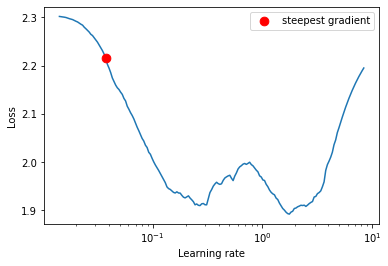

(<matplotlib.axes._subplots.AxesSubplot at 0x7f0444bc5f40>,
 0.03739937302478798)

In [ ]:
optimizer = torch.optim.SGD(net3.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(net3, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=10, num_iter=200)
lr_finder.plot() 

In [ ]:
min_loss = min(lr_finder.history['loss'])
ler_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
print("Max LR is {}".format(ler_rate))

Max LR is 1.762914118095948


In [ ]:
net3 = Net3(drop=0.0).to(device)
optimizer = torch.optim.SGD(net3.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=ler_rate,
                                                steps_per_epoch=len(train_loader), 
                                                epochs=24,
                                                pct_start=0.2,
                                                div_factor=10,
                                                three_phase=False, 
                                                final_div_factor=50,
                                                anneal_strategy='linear'
                                                ) #final_div_factor=100,
net, history = fit_model(
    net=net3, device=device,
    criterion = nn.CrossEntropyLoss(),
    train_loader=train_loader, test_loader=test_loader,
    optimizer=optimizer, 
    scheduler=scheduler, 
    NUM_EPOCHS=24
)

EPOCH: 1 (LR: 0.1762914118095948)


Batch_id=97 Loss=1.96173 Accuracy=26.97%: 100%|██████████| 98/98 [00:17<00:00,  5.69it/s]



Test set: Average loss: 1.9030, Accuracy: 3705/10000 (37.05%)

EPOCH: 2 (LR: 0.5075419981241721)


Batch_id=97 Loss=1.69032 Accuracy=38.08%: 100%|██████████| 98/98 [00:18<00:00,  5.42it/s]



Test set: Average loss: 1.5221, Accuracy: 4505/10000 (45.05%)

EPOCH: 3 (LR: 0.8387925844387494)


Batch_id=97 Loss=1.57549 Accuracy=43.01%: 100%|██████████| 98/98 [00:13<00:00,  7.41it/s]



Test set: Average loss: 1.4314, Accuracy: 4821/10000 (48.21%)

EPOCH: 4 (LR: 1.1700431707533268)


Batch_id=97 Loss=1.49775 Accuracy=46.26%: 100%|██████████| 98/98 [00:12<00:00,  7.67it/s]



Test set: Average loss: 1.4266, Accuracy: 4938/10000 (49.38%)

EPOCH: 5 (LR: 1.5012937570679041)


Batch_id=97 Loss=1.42596 Accuracy=49.20%: 100%|██████████| 98/98 [00:13<00:00,  7.14it/s]



Test set: Average loss: 1.2898, Accuracy: 5478/10000 (54.78%)

EPOCH: 6 (LR: 1.7436521076946347)


Batch_id=97 Loss=1.35053 Accuracy=52.10%: 100%|██████████| 98/98 [00:13<00:00,  7.40it/s]



Test set: Average loss: 1.1218, Accuracy: 6076/10000 (60.76%)

EPOCH: 7 (LR: 1.6520173009311059)


Batch_id=97 Loss=1.30390 Accuracy=53.81%: 100%|██████████| 98/98 [00:13<00:00,  7.18it/s]



Test set: Average loss: 1.1046, Accuracy: 6056/10000 (60.56%)

EPOCH: 8 (LR: 1.5603824941675768)


Batch_id=97 Loss=1.25684 Accuracy=55.33%: 100%|██████████| 98/98 [00:14<00:00,  6.79it/s]



Test set: Average loss: 1.3765, Accuracy: 5601/10000 (56.01%)

EPOCH: 9 (LR: 1.468747687404048)


Batch_id=97 Loss=1.22066 Accuracy=57.05%: 100%|██████████| 98/98 [00:14<00:00,  6.76it/s]



Test set: Average loss: 0.9680, Accuracy: 6600/10000 (66.00%)

EPOCH: 10 (LR: 1.3771128806405188)


Batch_id=97 Loss=1.18599 Accuracy=58.20%: 100%|██████████| 98/98 [00:13<00:00,  7.18it/s]



Test set: Average loss: 1.0120, Accuracy: 6571/10000 (65.71%)

EPOCH: 11 (LR: 1.28547807387699)


Batch_id=97 Loss=1.15935 Accuracy=59.22%: 100%|██████████| 98/98 [00:13<00:00,  7.22it/s]



Test set: Average loss: 0.9477, Accuracy: 6845/10000 (68.45%)

EPOCH: 12 (LR: 1.193843267113461)


Batch_id=97 Loss=1.12479 Accuracy=60.41%: 100%|██████████| 98/98 [00:13<00:00,  7.53it/s]



Test set: Average loss: 0.9108, Accuracy: 6899/10000 (68.99%)

EPOCH: 13 (LR: 1.102208460349932)


Batch_id=97 Loss=1.10545 Accuracy=61.25%: 100%|██████████| 98/98 [00:12<00:00,  7.58it/s]



Test set: Average loss: 0.8407, Accuracy: 7173/10000 (71.73%)

EPOCH: 14 (LR: 1.0105736535864032)


Batch_id=97 Loss=1.10106 Accuracy=61.33%: 100%|██████████| 98/98 [00:13<00:00,  7.51it/s]



Test set: Average loss: 0.8732, Accuracy: 6915/10000 (69.15%)

EPOCH: 15 (LR: 0.9189388468228742)


Batch_id=97 Loss=1.06556 Accuracy=62.46%: 100%|██████████| 98/98 [00:12<00:00,  7.58it/s]



Test set: Average loss: 0.9136, Accuracy: 6984/10000 (69.84%)

EPOCH: 16 (LR: 0.8273040400593451)


Batch_id=97 Loss=1.04208 Accuracy=63.45%: 100%|██████████| 98/98 [00:12<00:00,  7.71it/s]



Test set: Average loss: 0.8077, Accuracy: 7216/10000 (72.16%)

EPOCH: 17 (LR: 0.7356692332958161)


Batch_id=97 Loss=1.03028 Accuracy=63.78%: 100%|██████████| 98/98 [00:12<00:00,  7.54it/s]



Test set: Average loss: 0.7420, Accuracy: 7434/10000 (74.34%)

EPOCH: 18 (LR: 0.6440344265322873)


Batch_id=97 Loss=1.00038 Accuracy=64.89%: 100%|██████████| 98/98 [00:13<00:00,  7.49it/s]



Test set: Average loss: 0.7668, Accuracy: 7351/10000 (73.51%)

EPOCH: 19 (LR: 0.5523996197687582)


Batch_id=97 Loss=0.99059 Accuracy=65.19%: 100%|██████████| 98/98 [00:12<00:00,  7.57it/s]



Test set: Average loss: 0.7054, Accuracy: 7573/10000 (75.73%)

EPOCH: 20 (LR: 0.4607648130052291)


Batch_id=97 Loss=0.96789 Accuracy=65.99%: 100%|██████████| 98/98 [00:13<00:00,  7.49it/s]



Test set: Average loss: 0.6787, Accuracy: 7617/10000 (76.17%)

EPOCH: 21 (LR: 0.36913000624170045)


Batch_id=97 Loss=0.94196 Accuracy=66.68%: 100%|██████████| 98/98 [00:13<00:00,  7.45it/s]



Test set: Average loss: 0.6988, Accuracy: 7590/10000 (75.90%)

EPOCH: 22 (LR: 0.27749519947817136)


Batch_id=97 Loss=0.92681 Accuracy=67.16%: 100%|██████████| 98/98 [00:13<00:00,  7.48it/s]



Test set: Average loss: 0.6653, Accuracy: 7741/10000 (77.41%)

EPOCH: 23 (LR: 0.18586039271464228)


Batch_id=97 Loss=0.90134 Accuracy=68.42%: 100%|██████████| 98/98 [00:12<00:00,  7.65it/s]



Test set: Average loss: 0.6419, Accuracy: 7751/10000 (77.51%)

EPOCH: 24 (LR: 0.09422558595111341)


Batch_id=97 Loss=0.87644 Accuracy=69.06%: 100%|██████████| 98/98 [00:13<00:00,  7.49it/s]



Test set: Average loss: 0.6267, Accuracy: 7830/10000 (78.30%)



In [ ]:
# LAST MODEL
import torch.nn as nn
import torch.nn.functional as F

#depthwise separable convolution
class DepthwiseSeparable(nn.Module):
  def __init__(self, in_ch, out_ch, stride=1):
    super(DepthwiseSeparable, self).__init__()
    self.in_chan = in_ch
    self.out_chan = out_ch

    self.depthwise = nn.Sequential(
          nn.Conv2d(in_channels=self.in_chan, out_channels=self.in_chan, kernel_size=(3, 3), padding=1, stride=stride, groups=self.in_chan, bias=False),
          #pointwise
          nn.Conv2d(in_channels=self.in_chan, out_channels=self.out_chan, kernel_size=(1,1)))

  def forward(self, x):
    x = self.depthwise(x)
    return x

class Net4(nn.Module):
    def __init__(self, drop=0.025):
        super(Net4, self).__init__()

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(drop),
            DepthwiseSeparable(32,32,2), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(drop),
        )

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, dilation=2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(drop),
            DepthwiseSeparable(64,64,2), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(drop),
        )

        self.convblock3 =  nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3, 3), padding=1, dilation=2, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(drop),
        )

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(3, 3), padding=1, bias=False), 

        ) 

        self.gap = nn.AvgPool2d(4)

    def forward(self, x):
        x =  self.convblock1(x)
        #print(x.shape)
        x =  self.convblock2(x)
        #print(x.shape)
        x =  self.convblock3(x)
        #print(x.shape)
        x =  self.convblock4(x)
        #print(x.shape)
        x =  self.gap(x)
        #print(x.shape)
        x = x.view(-1, 10)
        #print(x.shape)
        
        return F.log_softmax(x, dim=-1)

In [ ]:

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
net4 = Net4(drop=0.0).to(device)
summary(net4, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 16, 16]             288
            Conv2d-6           [-1, 32, 16, 16]           1,056
DepthwiseSeparable-7           [-1, 32, 16, 16]               0
       BatchNorm2d-8           [-1, 32, 16, 16]              64
              ReLU-9           [-1, 32, 16, 16]               0
          Dropout-10           [-1, 32, 16, 16]               0
           Conv2d-11           [-1, 64, 14, 14]          18,432
      BatchNorm2d-12           [-1, 64, 14, 14]             128
             ReLU-13           [-1, 64, 14, 14]               0
          Dropout-14           [-1

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.77E-02


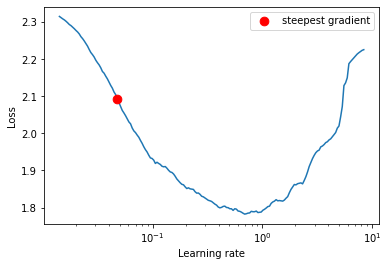

(<matplotlib.axes._subplots.AxesSubplot at 0x7f0444c36b20>, 0.0476861169771447)

In [ ]:
net4 = Net4(drop=0.0).to(device)
import copy
net4_exp = copy.deepcopy(net4)
optimizer = torch.optim.SGD(net4_exp.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(net4_exp, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=10, num_iter=200)
lr_finder.plot() 

In [ ]:
min_loss = min(lr_finder.history['loss'])
ler_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
print("Max LR is {}".format(ler_rate))

Max LR is 0.6905513520162327


In [ ]:
optimizer = torch.optim.SGD(net4.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=ler_rate,
                                                steps_per_epoch=len(train_loader), 
                                                epochs=24,
                                                pct_start=0.2,
                                                div_factor=10,
                                                three_phase=False, 
                                                final_div_factor=50,
                                                anneal_strategy='linear'
                                                ) #final_div_factor=100,
net, history = fit_model(
    net=net4, device=device,
    criterion = nn.CrossEntropyLoss(),
    train_loader=train_loader, test_loader=test_loader,
    optimizer=optimizer, 
    scheduler=scheduler, 
    NUM_EPOCHS=24
)

EPOCH: 1 (LR: 0.06905513520162328)


Batch_id=97 Loss=1.86998 Accuracy=30.80%: 100%|██████████| 98/98 [00:12<00:00,  7.96it/s]



Test set: Average loss: 1.5852, Accuracy: 4289/10000 (42.89%)

EPOCH: 2 (LR: 0.19880935175005043)


Batch_id=97 Loss=1.59457 Accuracy=42.15%: 100%|██████████| 98/98 [00:14<00:00,  6.70it/s]



Test set: Average loss: 1.3598, Accuracy: 5197/10000 (51.97%)

EPOCH: 3 (LR: 0.3285635682984776)


Batch_id=97 Loss=1.49320 Accuracy=45.81%: 100%|██████████| 98/98 [00:12<00:00,  7.72it/s]



Test set: Average loss: 1.4220, Accuracy: 5153/10000 (51.53%)

EPOCH: 4 (LR: 0.4583177848469048)


Batch_id=97 Loss=1.41005 Accuracy=49.46%: 100%|██████████| 98/98 [00:12<00:00,  7.77it/s]



Test set: Average loss: 1.1906, Accuracy: 5955/10000 (59.55%)

EPOCH: 5 (LR: 0.588072001395332)


Batch_id=97 Loss=1.33451 Accuracy=52.37%: 100%|██████████| 98/98 [00:13<00:00,  7.49it/s]



Test set: Average loss: 1.0752, Accuracy: 6243/10000 (62.43%)

EPOCH: 6 (LR: 0.683006227050336)


Batch_id=97 Loss=1.27919 Accuracy=54.53%: 100%|██████████| 98/98 [00:12<00:00,  7.63it/s]



Test set: Average loss: 1.0693, Accuracy: 6330/10000 (63.30%)

EPOCH: 7 (LR: 0.6471119432319923)


Batch_id=97 Loss=1.22826 Accuracy=56.66%: 100%|██████████| 98/98 [00:12<00:00,  7.59it/s]



Test set: Average loss: 0.9447, Accuracy: 6774/10000 (67.74%)

EPOCH: 8 (LR: 0.6112176594136485)


Batch_id=97 Loss=1.18961 Accuracy=57.88%: 100%|██████████| 98/98 [00:12<00:00,  7.54it/s]



Test set: Average loss: 0.8604, Accuracy: 6984/10000 (69.84%)

EPOCH: 9 (LR: 0.5753233755953047)


Batch_id=97 Loss=1.15925 Accuracy=59.10%: 100%|██████████| 98/98 [00:12<00:00,  7.59it/s]



Test set: Average loss: 0.9874, Accuracy: 6677/10000 (66.77%)

EPOCH: 10 (LR: 0.539429091776961)


Batch_id=97 Loss=1.13266 Accuracy=60.05%: 100%|██████████| 98/98 [00:12<00:00,  7.91it/s]



Test set: Average loss: 0.8182, Accuracy: 7167/10000 (71.67%)

EPOCH: 11 (LR: 0.5035348079586172)


Batch_id=97 Loss=1.10625 Accuracy=60.92%: 100%|██████████| 98/98 [00:12<00:00,  7.85it/s]



Test set: Average loss: 0.8730, Accuracy: 7013/10000 (70.13%)

EPOCH: 12 (LR: 0.46764052414027346)


Batch_id=97 Loss=1.09991 Accuracy=61.27%: 100%|██████████| 98/98 [00:12<00:00,  7.73it/s]



Test set: Average loss: 0.8716, Accuracy: 7004/10000 (70.04%)

EPOCH: 13 (LR: 0.43174624032192965)


Batch_id=97 Loss=1.07186 Accuracy=62.34%: 100%|██████████| 98/98 [00:12<00:00,  7.82it/s]



Test set: Average loss: 0.7774, Accuracy: 7316/10000 (73.16%)

EPOCH: 14 (LR: 0.3958519565035859)


Batch_id=97 Loss=1.05490 Accuracy=62.86%: 100%|██████████| 98/98 [00:12<00:00,  7.84it/s]



Test set: Average loss: 0.7534, Accuracy: 7420/10000 (74.20%)

EPOCH: 15 (LR: 0.35995767268524215)


Batch_id=97 Loss=1.04112 Accuracy=63.37%: 100%|██████████| 98/98 [00:12<00:00,  7.63it/s]



Test set: Average loss: 0.7427, Accuracy: 7440/10000 (74.40%)

EPOCH: 16 (LR: 0.32406338886689834)


Batch_id=97 Loss=1.01929 Accuracy=64.04%: 100%|██████████| 98/98 [00:12<00:00,  7.91it/s]



Test set: Average loss: 0.7306, Accuracy: 7505/10000 (75.05%)

EPOCH: 17 (LR: 0.2881691050485546)


Batch_id=97 Loss=1.00173 Accuracy=64.96%: 100%|██████████| 98/98 [00:12<00:00,  7.87it/s]



Test set: Average loss: 0.7085, Accuracy: 7566/10000 (75.66%)

EPOCH: 18 (LR: 0.25227482123021083)


Batch_id=97 Loss=0.98966 Accuracy=65.21%: 100%|██████████| 98/98 [00:12<00:00,  7.89it/s]



Test set: Average loss: 0.7242, Accuracy: 7527/10000 (75.27%)

EPOCH: 19 (LR: 0.21638053741186708)


Batch_id=97 Loss=0.97736 Accuracy=65.63%: 100%|██████████| 98/98 [00:12<00:00,  7.80it/s]



Test set: Average loss: 0.6655, Accuracy: 7693/10000 (76.93%)

EPOCH: 20 (LR: 0.18048625359352333)


Batch_id=97 Loss=0.96144 Accuracy=66.26%: 100%|██████████| 98/98 [00:12<00:00,  7.85it/s]



Test set: Average loss: 0.6990, Accuracy: 7645/10000 (76.45%)

EPOCH: 21 (LR: 0.14459196977517952)


Batch_id=97 Loss=0.94168 Accuracy=66.88%: 100%|██████████| 98/98 [00:12<00:00,  7.65it/s]



Test set: Average loss: 0.6575, Accuracy: 7743/10000 (77.43%)

EPOCH: 22 (LR: 0.10869768595683582)


Batch_id=97 Loss=0.92565 Accuracy=67.57%: 100%|██████████| 98/98 [00:12<00:00,  7.88it/s]



Test set: Average loss: 0.6331, Accuracy: 7813/10000 (78.13%)

EPOCH: 23 (LR: 0.07280340213849201)


Batch_id=97 Loss=0.90627 Accuracy=68.22%: 100%|██████████| 98/98 [00:12<00:00,  7.76it/s]



Test set: Average loss: 0.6195, Accuracy: 7863/10000 (78.63%)

EPOCH: 24 (LR: 0.036909118320148315)


Batch_id=97 Loss=0.88325 Accuracy=68.86%: 100%|██████████| 98/98 [00:12<00:00,  7.94it/s]



Test set: Average loss: 0.6004, Accuracy: 7903/10000 (79.03%)

